In [1]:
import gym
import gym_Snake
import time
import sys
from IPython.display import clear_output
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

#### QLearning algorithm

In [2]:
class QLearning:
    def __init__(self, n_actions, n_states, discount=0.9, alpha = 0.01, epsilon=0.1, decay = 0):
        self.n_actions = n_actions
        self.n_states = n_states
        self.Q = np.zeros([n_states, n_actions])
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.decay = decay
        self.state = 0  # Set initial state

    def act(self):
        ## by default, act greedily
        if (np.random.uniform() < self.epsilon):
            return np.random.randint(self.n_actions)
        return np.argmax(self.Q[self.state, :])

    def update(self, action, reward, state):
        ## fill in
        Q_max = max(self.Q[state, :])
        self.Q[self.state, action] = self.alpha * (reward + self.discount * Q_max) + (1 - self.alpha) * self.Q[self.state, action]
        self.state = state

    def reset(self, state):
        self.state = state

In [3]:
class QLearning2:
    def __init__(self, n_actions, n_states, discount=0.9, alpha = 0.01, epsilon=0.9, min_epsilon = 0.1, decay = 0):
        self.n_actions = n_actions
        self.n_states = n_states
        self.Q = np.zeros([n_states, n_actions])
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.chronology = []
        
    def act(self):
        if self.epsilon > self.min_epsilon: self.epsilon = 1 / (1 / self.epsilon + self.decay)
        if (np.random.uniform() < self.epsilon):
            return np.random.choice(self.n_actions)
        return np.argmax(self.Q[self.state, :])
    
    def update(self, action, reward, state, add_batch=True):
        if add_batch: self.chronology.append([self.state, action, reward, state])
        self.Q[self.state, action] += self.alpha * np.max(reward + self.discount * self.Q[state, :] - self.Q[self.state, action])
        self.alpha += 1 / ( self.alpha + self.decay)
        self.state = state

    def reset(self, state):
        self.state = state
        
    def play_batch(self, nb_batchs):
        prev_state = self.state
        arr = np.array(self.chronology)
        for s,a,r,sn in arr[np.random.choice(arr.shape[0], size=nb_batchs, replace=False), :]:
            # Reset position
            self.reset(s)
            # Update algorithm
            self.update(a, r, sn, add_batch = False)
        # Reset real state
        self.reset(prev_state)


In [4]:
class SARSA:
    def __init__(self, n_actions, n_states, discount=0.9, alpha = 0.01, epsilon=0.1, decay = 0):
        self.n_actions = n_actions
        self.n_states = n_states
        self.Q = np.zeros([n_states, n_actions])
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.decay = decay
        self.state = 0  # Set initial state

    def act(self):
        ## by default, act greedily
        if (np.random.uniform() < self.epsilon):
            return np.random.randint(self.n_actions)
        return np.argmax(self.Q[self.state, :])

    def update(self, action, reward, state):
        ## fill in
        next_action = np.argmax(self.Q[state, :])
        self.Q[self.state, action] = self.alpha * (reward + self.discount * self.Q[state, next_action]) + (1 - self.alpha) * self.Q[self.state, action]
        self.state = state

    def reset(self, state):
        self.state = state

#### Create env

In [5]:
env = gym.make('Snake-v0', 
               player='computer', 
               shape='Normal', 
               state_mode='states', 
               reward_mode = 'extended', 
               width=9, 
               height=9, 
               solid_border=True)
print(env.observation_space)
print(env.action_space)

Discrete(1024)
Discrete(3)


#### Init QLearning algorithm

In [6]:
QL = QLearning(n_actions = env.action_space.n, n_states = env.observation_space.n, alpha = 0.05)
QL2 = QLearning2(n_actions = env.action_space.n,
                 n_states = env.observation_space.n, 
                 discount=0.995, 
                 alpha = 0.1, 
                 epsilon=0.99, 
                 decay = 0.00001)
SA = SARSA(n_actions = env.action_space.n, n_states = env.observation_space.n)

In [7]:
def play_epoch(algo, env, render = False):
    
    # Reset env
    obs = env.reset()
    algo.reset(obs)

    done = False
    
    # Sum the rewards
    total_rew = 0
    
    while not done:
        # Show
        if render: env.render()
        # Choose next action
        new_act = algo.act()
        # Act in the env
        obs, reward, done, info = env.step(np.random.randint(3))
        # Store reward
        total_rew += reward
        # Update algorithm
        algo.update(new_act, reward, obs)
        # Slow render
        if render: time.sleep(0.5)
            
    # Return total reward
    return total_rew

#### Train

In [8]:
render = True

nb_iterations = 50000

rewards = []
eps = []

my_algo = QL2

# Train
for i in tqdm(range(nb_iterations)):
    r = play_epoch(algo = my_algo, env = env, render = False)
    rewards.append(r)
    eps.append(my_algo.epsilon)
    if i > 1000 and i % 1000 == 0:
        my_algo.play_batch(i - 1)
    

# Visualize results
# play_epoch(algo = QL, env = env, render = True)

  0%|                                       | 64/50000 [00:00<01:19, 631.69it/s]/tmp/ipykernel_5896/3552143727.py:21: RuntimeWarning: overflow encountered in double_scalars
  self.Q[self.state, action] += self.alpha * np.max(reward + self.discount * self.Q[state, :] - self.Q[self.state, action])
/tmp/ipykernel_5896/3552143727.py:21: RuntimeWarning: invalid value encountered in subtract
  self.Q[self.state, action] += self.alpha * np.max(reward + self.discount * self.Q[state, :] - self.Q[self.state, action])
/tmp/ipykernel_5896/3552143727.py:21: RuntimeWarning: invalid value encountered in double_scalars
  self.Q[self.state, action] += self.alpha * np.max(reward + self.discount * self.Q[state, :] - self.Q[self.state, action])
100%|████████████████████████████████████| 50000/50000 [01:23<00:00, 598.86it/s]


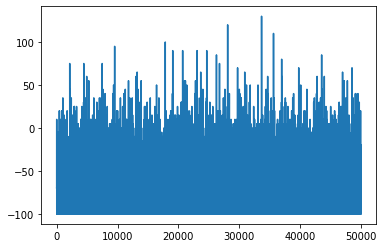

In [9]:
plt.plot(range(len(rewards)), rewards)

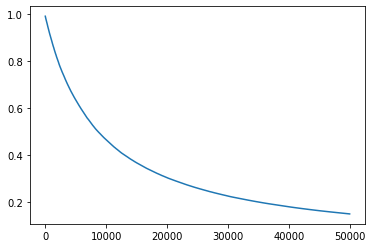

In [10]:
plt.plot(range(len(eps)), eps)

#### Visualize results

In [14]:
# Replay with last policy
old_eps = my_algo.epsilon
my_algo.epsilon = 0
play_epoch(algo = my_algo, env = env, render = True)
my_algo.epsilon = old_eps

In [12]:
my_algo.epsilon

0.14823553002802223